# 1. Import libraries
Add these modules to your project libraries if you don't have them already.

In [10]:
import librosa #If you receive an error with librosa.load, you may need to install ffmpeg.
import os
import numpy as np
import glob
from glob import iglob
import matplotlib.pyplot as plt
import librosa.display

# 2. Load some songs

Here we import n songs (I used n=9) in order to visualize the effect of different parameters on the final spectrogram 

In [11]:
n_songs = 9                            # number of songs to import, just to explore data
rootdir_glob = "../data/genres/**"     # put here path to songs


# This will return a matrix with the n songs, one per row
songs = np.zeros((0,661500))

for filename in glob.iglob(rootdir_glob, recursive=True):
    if os.path.isfile(filename): # filter dirs
        x, sampleRate = librosa.load(filename, duration = 30)
        songs = np.vstack( [songs, x] )
        if(len(songs[:]) > n_songs):
            break

print('Done importing songs')

Done importing songs


# 3. Show waveforms

Show the raw waveform of the imported songs

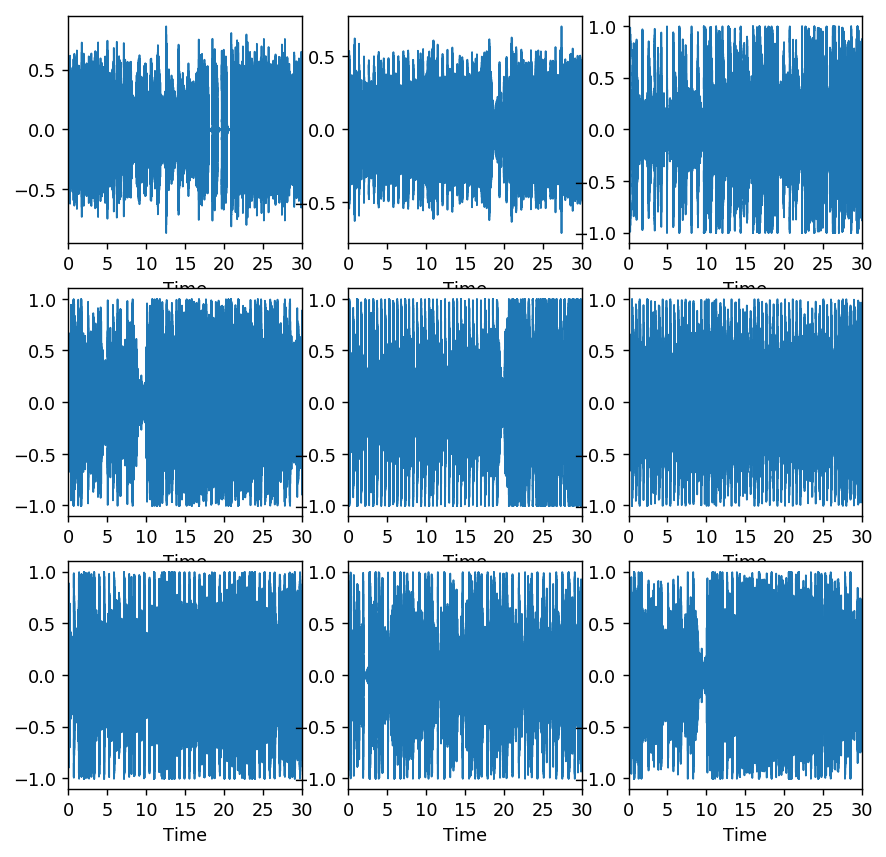

In [12]:
plt.figure(figsize=(8, 8), dpi=128)
for i in range(1, len(songs[:])):
    plt.subplot(3, 3, i)
    librosa.display.waveplot(songs[i], sr=sampleRate)

# 4. Show spectograms
Show spectrogram of the song. Here we can try different settings to see the effect on the output. To get inspiration, see the summary of the papers of the next section.

In [ ]:
plt.figure(figsize=(12, 12))

for i in range(1, len(songs[:])):
    plt.subplot(3, 3, i)
    #X = librosa.stft(songs[i])#Old code 
    X = librosa.feature.melspectrogram(songs[i])
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sampleRate,  cmap='plasma', x_axis='time', y_axis='mel')

# 5. Preprocess all data and save spectrograms

## Some remarks about preprocessing w.r.t. the state of the art classifiers:

#### "Deep Music Genre" paper: 
prepocessed as melspectograms. The window size was set to 2048, and the mel and the frequency
bins to 128. The spectograms are then normalized by subtracting the mean and dividing by the standard deviation. 

The dataset is splitted into 33% for validation and the rest for training using Adam
optimizer (accuracy of 56.12% in the training set and 58.79% in the validation set.). For MagnaTagATune, the dataset is splitted into 20% for test and 80% for training (accuracy of 48.48% on the training set and of 46.96% on the validation set). 

#### "Music Genre Classification" paper:

*NOTE WELL*: paper suggests that there is essentially no benefit to looking directly at raw amplitude data, while mel spectogram leads to best perfomance

Two types of preprocessing:
1. (Worse accuracy) From each clip, we sampled a contiguous 2-second window at four random locations, thus augmenting our data to 8000 clips of two seconds each. Since this data was sampled at 22050HZ, this leaves us with 44100 features for the raw audio input. We restricted our windows to two seconds to limit the number of features. We found that 44100 features was the perfect balance
between length of audio sample and dimension of feature space. Thus after pre-processing our input is of shape (8000,
CS229 Final Report - Music Genre Classification 44100), where each feature denotes the amplitude at a certain timestep out of the 44100. We also used 100 samples of un-augmented data each of our cross validation and test sets.

2. (Best accuracy) We also experimented with pre-processing our data by converting the raw audio into mel-spectrograms. In doing this,
we experienced significant performance increases across all models. Mel-spectograms are a commonly used method of
featurizing audio because they closely represent how humans perceive audio (i.e. in log frequency). the parameter used are 64 mel-bins and a window length of 512 samples with an overlap of 50% between windows. Based on previous academic success with such transformations, we then move to log-scaling using the formula log(X2). (training acc: 95%, test acc: 82%)



#### "Automatic Classification of Music Genre using Masked Conditional Neural Networks":

*NOTE WELL*: this paper makes use of the Ballroom dataset (only 8 genres for latin dances). They explored the ConditionaL Neural Network (CLNN) and the Masked ConditionaL Neural Network designed for multidimensional temporal signal recognition. MCLNN outperformed several state-of-the-art handcrafted and Convolutional Neural Networks.

As an initial processing step, we resampled the files to a monaural 16-bit word depth wav format at a sampling rate of 22050 Hz. All files underwent a spectrogram transformation to a 256 frequency bin logarithmic mel-scaled spectrogram with an FFT window of 2048 sample and 50% overlap.

Further preprocessing involved extracting segments following (4). We followed a 10-fold cross-validation to report the accuracies, where the training folds are standardized, and the z-score parameters are applied on the validation and test folds (final accuracy 92.12 ± 2.94).

#### "Music Artist Classification with Convolutional Recurrent Neural Networks" paper

*NOTE WELL*: this paper makes use of the artist20 music artist identification dataset, so some observations may not apply to our problem (recognizign a band is different than recognizing a genre)

A short-time Fourier transform is applied to the raw audio signal for every song to create spectrograms. Once converted, the
frequency scale (f hertz) is transformed into the Mel scale (mels) and then scaled (d decibels) using these parameters:
 - Sampling Rate 16 kHz (this is set at the specified value for audio tracks in the artist20 dataset)
 - Number of Mel Bins 128
 - FFT Window Size 2048
 - Hop Length 512
 - Reference Power for Log-Scaling (r) 1.0

Spectrograms are created for the entire length of each song to form an initial dataset. For the song split,
this dataset undergoes a 90/10 stratified-by-artist split to create train and test sets respectively. The train set is then split using the same stratified 90/10 split to create train and validation (used for early stopping) subsets. The stratification ensures that each set contains an equivalent number of songs from each artist. For the album split, two albums from each artist are randomly removed from the initial dataset—one is added to the test set and the other to validation. The remaining four albums from each artist are joined to form the training set.

There is a trade-off between the training set size and the length of each audio clip. Longer clips contain more temporal structure within each training sample while shorter clips can be shuffled and interpreted as a larger set of independent training samples.

The best-performing three second (3s) case achieves average and best test F1 scores of 0.937 and 0.966 respectively. As the audio length is increased beyond three seconds though, performance begins to diminish and this is likely because the noise rejection from voting using a larger number of test samples outweighs additional temporal benefit. we advise using an artist’s discography for training and song level evaluation with three to ten second long audio samples when possible. These explanations also imply that excessive temporal information is lost, likely to early pooling layers, when a sample passes through the network. 

Another interpretation involves the minor translational invariance associated with pooling. While this is desirable in image
classification tasks and necessary for computational reasons, it may be detrimental when spatial location has meaning relevant
to the classification.


In [8]:
#########################################
##########  Output parameters  ##########
#########################################
'''
rootdir_glob = "../data/genres/**"      # songs parent folder
path_save = "../data/spectrograms/"     # folder where to store outputs spectograms
size_image = 128                        # will be saved as [size_image x size_image x 3 channels] with bit depth of 32

sampling_rate = sampleRate                     # Sample rate used to determine time scale in x-axis (taken from the song files).
hop_length = 512                        # Hop length, also used to determine time scale in x-axis (not used yet)
y = 'mel'                               # Frequency types

#########################################
##########     Preprocess      ##########
#########################################

i = 
for filename in glob.iglob(rootdir_glob, recursive=True):
    if os.path.isfile(filename): # filter dirs
        x, sampleRate = librosa.load(filename, duration = 30)
        fig = plt.figure(figsize=(1, 1), frameon=False,  dpi=size_image)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        #X = librosa.stft(x) Old way of creating the the spectrogram.
        X = librosa.feature.melspectrogram(x, sr=sampleRate) #Creating the melspectrogram
        Xdb = librosa.amplitude_to_db(abs(X))
        librosa.display.specshow(Xdb, sr=sampling_rate,  cmap='plasma', x_axis='time', y_axis=y)
        plt.savefig(path_save + 'spectrogram_'+ str("{:04d}".format(i)) + '.png',  transparent=True, pad_inches=0.0, dpi=size_image)
        plt.close(fig)
        i = i + 1

print('Conversion to spectograms complete.')
print('Converted songs: ' + str(i))
'''

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# 6. Create labels and save .txt file

In [9]:
path_save = "../data/"         # folder where to store label file
name_file = "labels.txt"       # name of created .txt file

labels = np.repeat(range(10), 100)     
labels = labels.astype(np.int64)
np.savetxt(path_save + name_file, labels, fmt="%d")
